In [1]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import jax
import matplotlib.pyplot as plt

from src.sdes import sde_utils, sde_ornstein_uhlenbeck, sde_data
from src import plotting

In [2]:
t_start = 0.
T = 1.
x0 = (5.,)
y = (0.,)
N = 50
num_trajectories = 100

key =  jr.PRNGKey(1)
traj_keys = jax.random.split(key, num_trajectories)

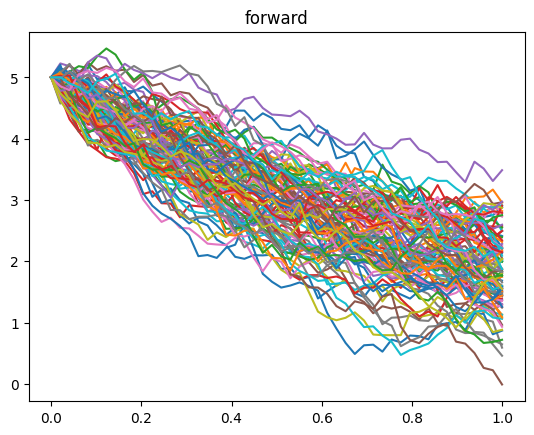

In [3]:
ou = sde_ornstein_uhlenbeck.ornstein_uhlenbeck(T, N, 1)
trajectory_generator = sde_data.data_forward(x0, ou)
_ts, trajectories, _corr = trajectory_generator(traj_keys)

for traj in trajectories:
    plt.plot(ou.time_grid, traj)
plt.title("forward")
plt.show()

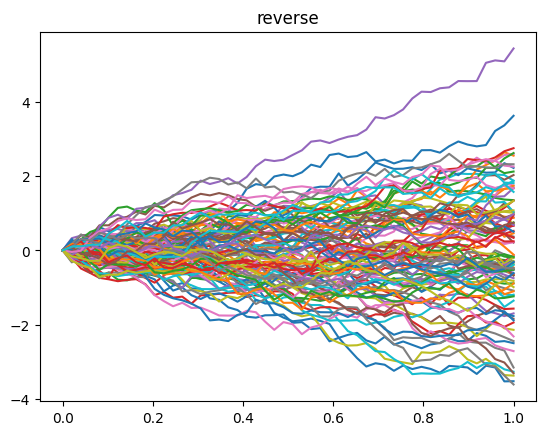

[3.6292415]


In [4]:
rev_keys = jax.random.split(key, num_trajectories)

with jax.disable_jit():
    rev_generator = sde_data.data_adjoint(y, ou)
    _ts, rev, _corr = rev_generator(rev_keys)

for traj in rev:
    plt.plot(ou.time_grid_reverse, traj)
plt.title("reverse")
plt.show()
print(rev[0][-1])

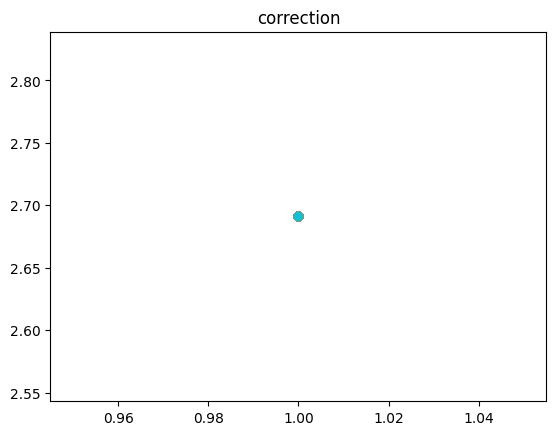

In [5]:
rev_corr_generator = sde_data.data_reverse_correction(y, ou)
ts, rev, corr = rev_corr_generator(rev_keys)

for correct in corr:
    plt.scatter(ts[0, -1], correct)
plt.title("correction")
plt.show()

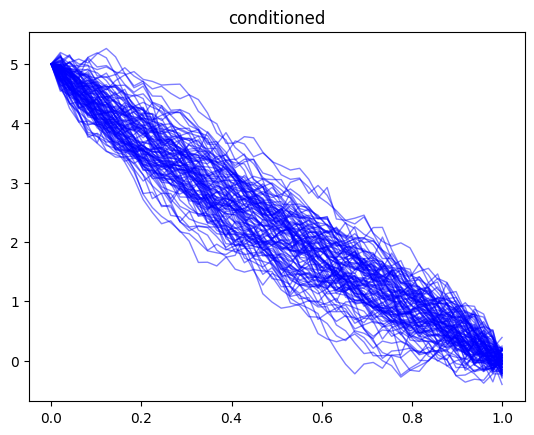

In [13]:
cond_keys = jax.random.split(key, num_trajectories)
score_fn = partial(ou.params[0], T=T, y=y)

cond = jax.vmap(sde_utils.conditioned, (0, None, None, None))(traj_keys, x0, ou, score_fn)

linewidth=1.
alpha=0.5

time_partial = ou.time_grid[::1]
cond_partial = cond[:, ::1]

for traj in cond_partial:
    plt.plot(time_partial, traj, linewidth=linewidth, alpha=alpha, color="blue")
plt.title("conditioned")
plt.show()


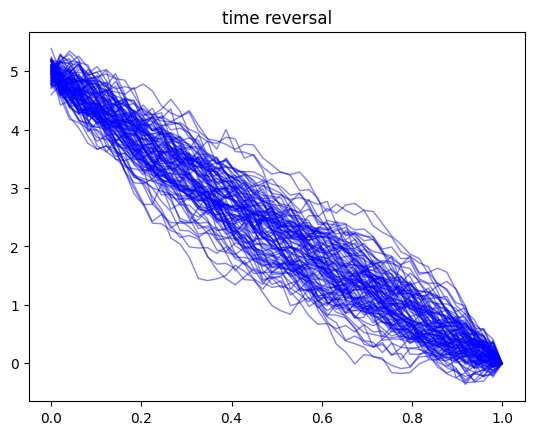

In [15]:
score_fn_fw = partial(ou.params[1], 0., jnp.asarray(x0))

time_rev = jax.vmap(sde_utils.time_reversal, (0, None, None, None))(traj_keys, y, ou, score_fn_fw)[:, ::-1]

time_rev_partial = time_rev[:, ::1]
time_grid_partial = ou.time_grid_reverse[::1]


for traj in time_rev_partial:
    plt.plot(time_grid_partial[:], traj[:], linewidth=linewidth, alpha=alpha, color="blue")
plt.title("time reversal")
plt.show()
